# 分析Z500上4DVar的调参结果

In [1]:
import os
import sys
sys.path.append("../")
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from src.utils.plot import subplot_daloop
from src.utils.data_utils import NAME_TO_VAR
from scipy.signal import exponential
import torch
from src.models.forecast.forecast_module import ForecastLitModule
from src.models.assimilate.fdvarcyclegan_assim_module import AssimilateLitModule as FdvarCycleGANAssimModule
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
DALOOP_DIR = "../../output/da_loop"
ERA5_DIR = "../../data/era5"
BACKGRDOUND_DIR = "../../data/background"
OBS_DIR = "../../data/obs"
MASK_DIR = "../../data/obs_mask"
VARIABLE = "geopotential"
LEVEL = 500
RESOLUTION = 5.625
CKPT_DIR = "../../ckpt/lt72"

In [3]:
gt = xr.open_mfdataset(f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/test/*.nc", combine="by_coords")
xb = xr.open_mfdataset(f"{BACKGRDOUND_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/test/*.nc", combine="by_coords")
obs = xr.open_mfdataset(f"{OBS_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/test/*.nc", combine="by_coords")
obs_mask = xr.open_mfdataset(f"{MASK_DIR}/test/*.nc", combine="by_coords")
mean = np.load(os.path.join(f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_5.625deg", 'normalize_mean.npy'))
std = np.load(os.path.join(f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_5.625deg", 'normalize_std.npy'))

## 绘制同化预报循环误差

In [4]:
forecast_model = ForecastLitModule.load_from_checkpoint(f"{CKPT_DIR}/afnonet_z500.ckpt",
                                                        mean_path=f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/normalize_mean.npy",
                                                        std_path=f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/normalize_std.npy",
                                                        clim_paths=[
                                                            f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/train/climatology.npy",
                                                            f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/val/climatology.npy",
                                                            f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/test/climatology.npy",
                                                        ]
)
forecast_net = forecast_model.net.cuda().eval()

/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [5]:
mult = forecast_model.mult
clim = forecast_model.clims[2]

In [6]:
assim_model = FdvarCycleGANAssimModule.load_from_checkpoint(f"{CKPT_DIR}/4dvarcyclegan_wscale_assim_z500.ckpt",
                                                            mean_path=f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/normalize_mean.npy",
                                                            std_path=f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/normalize_std.npy",
                                                            clim_paths=[
                                                                f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/train/climatology.npy",
                                                                f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/val/climatology.npy",
                                                                f"{ERA5_DIR}/{VARIABLE}_{LEVEL}_{RESOLUTION}deg/test/climatology.npy",
                                                            ],
                                                            pred_ckpt=f"{CKPT_DIR}/afnonet_z500.ckpt",
                                                            )
assim_net = assim_model.g_A2B.cuda().eval()

/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'g_A2B' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['g_A2B'])`.
  rank_zero_warn(
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'g_B2A' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['g_B2A'])`.
  rank_zero_warn(
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'd_A' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['d_A'])`.
  rank_zero_warn(
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/pyto

In [7]:
xb = xb.sel(init_time=-72)["z"].values[0:1]

In [8]:
init_data = torch.from_numpy((xb - mean) / std).to("cuda:0", dtype=torch.float32)
input_obs = torch.unsqueeze(torch.from_numpy((obs["z"].values[0:3]- mean) / std), dim=0).to("cuda:0", dtype=torch.float32)
input_mask = torch.unsqueeze(torch.from_numpy(obs_mask["mask"].values[0:3]), dim=0).to("cuda:0", dtype=torch.float32)
input_obs = input_obs * input_mask
with torch.set_grad_enabled(True):
    x_k = torch.autograd.Variable(init_data, requires_grad=True)
    raw_inc, scale_inc = assim_net.solve_increment(x_k, input_obs, input_mask)
raw_inc = raw_inc.detach().cpu().numpy() * std
scale_inc = scale_inc.detach().cpu().numpy() * std

In [9]:
nc_raw_inc = xr.DataArray(raw_inc[0,0], 
                          dims=["lat", "lon"],
                          coords={"lat": gt.lat, 
                                  "lon": gt.lon},
)

nc_scale_inc = xr.DataArray(scale_inc[0,0], 
                          dims=["lat", "lon"],
                          coords={"lat": gt.lat, 
                                  "lon": gt.lon},
)

/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/wangwx/anac

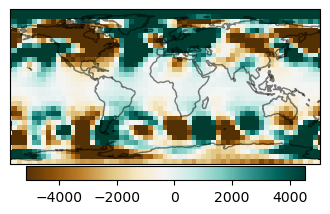

In [31]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
I = nc_raw_inc.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, rasterized=True, cmap='BrBG', vmin=np.min(raw_inc)/5, vmax=np.max(raw_inc)/5)
cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
ax.coastlines(alpha=0.5)
plt.savefig(f"raw_inc_{NAME_TO_VAR[f'{VARIABLE}_{LEVEL}']}{LEVEL}.png",dpi=300, bbox_inches="tight")
plt.savefig(f"raw_inc_{NAME_TO_VAR[f'{VARIABLE}_{LEVEL}']}{LEVEL}.pdf",dpi=300, bbox_inches="tight")

/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/wangwx/anaconda3/envs/ddwp/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/wangwx/anac

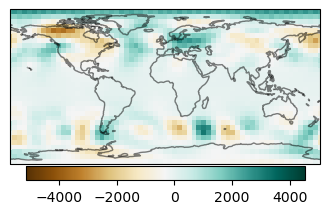

In [32]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
I = nc_scale_inc.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, rasterized=True, cmap='BrBG', vmin=np.min(raw_inc)/5, vmax=np.max(raw_inc)/5)
cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
ax.coastlines(alpha=0.5)
plt.savefig(f"scale_inc_{NAME_TO_VAR[f'{VARIABLE}_{LEVEL}']}{LEVEL}.png",dpi=300, bbox_inches="tight")
plt.savefig(f"scale_inc_{NAME_TO_VAR[f'{VARIABLE}_{LEVEL}']}{LEVEL}.pdf",dpi=300, bbox_inches="tight")